C:\Users\Gienon\AppData\Local\Temp\ipykernel_16436\102311777.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_lo

Model loaded successfully.


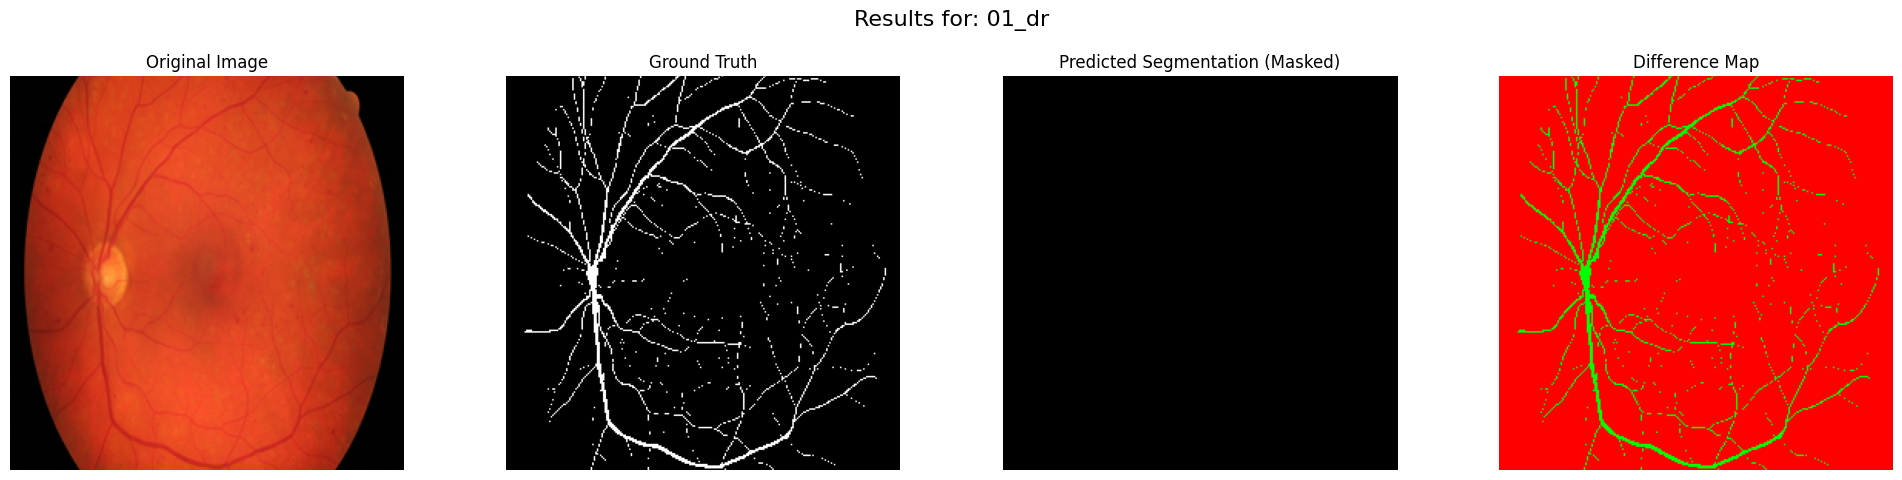

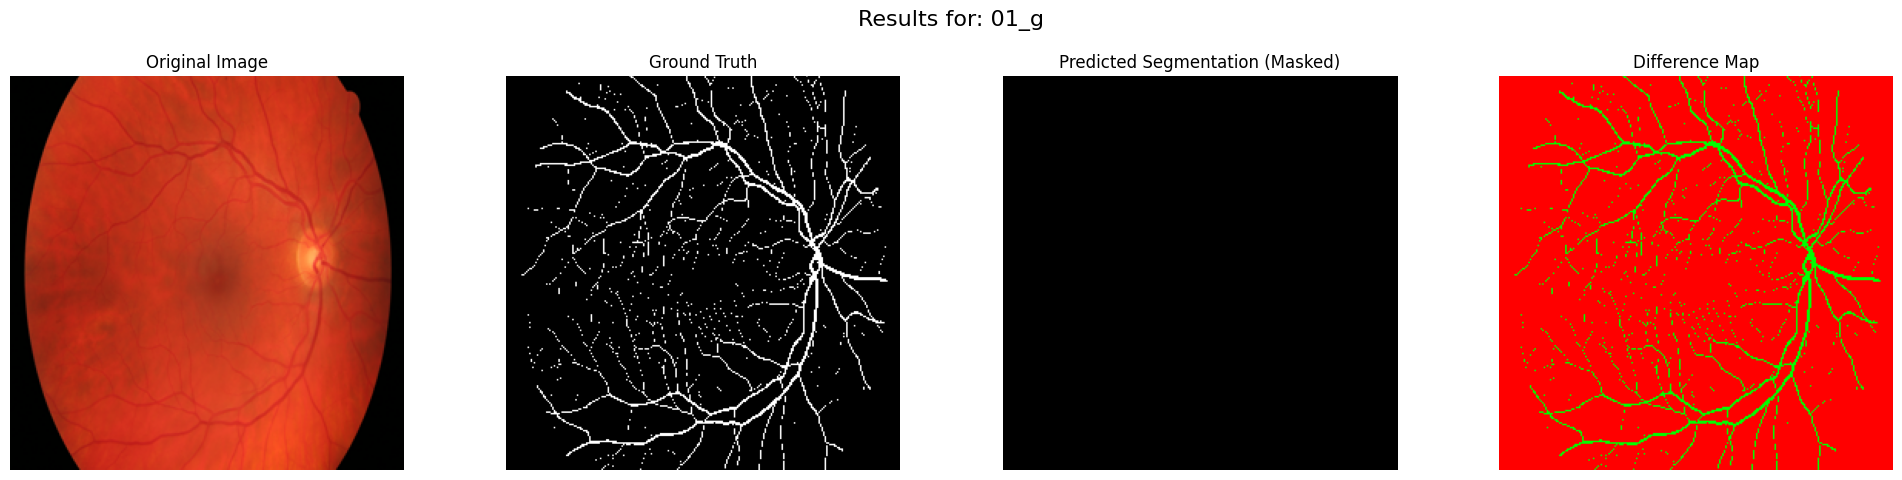

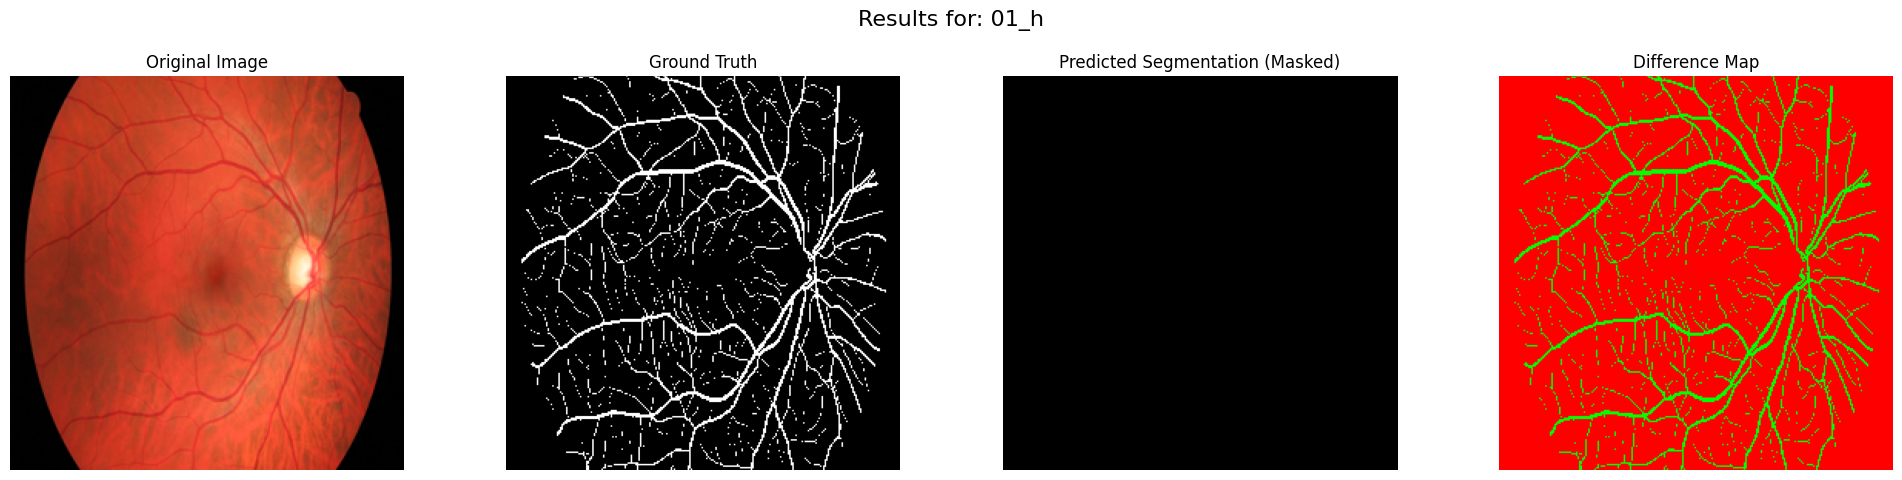

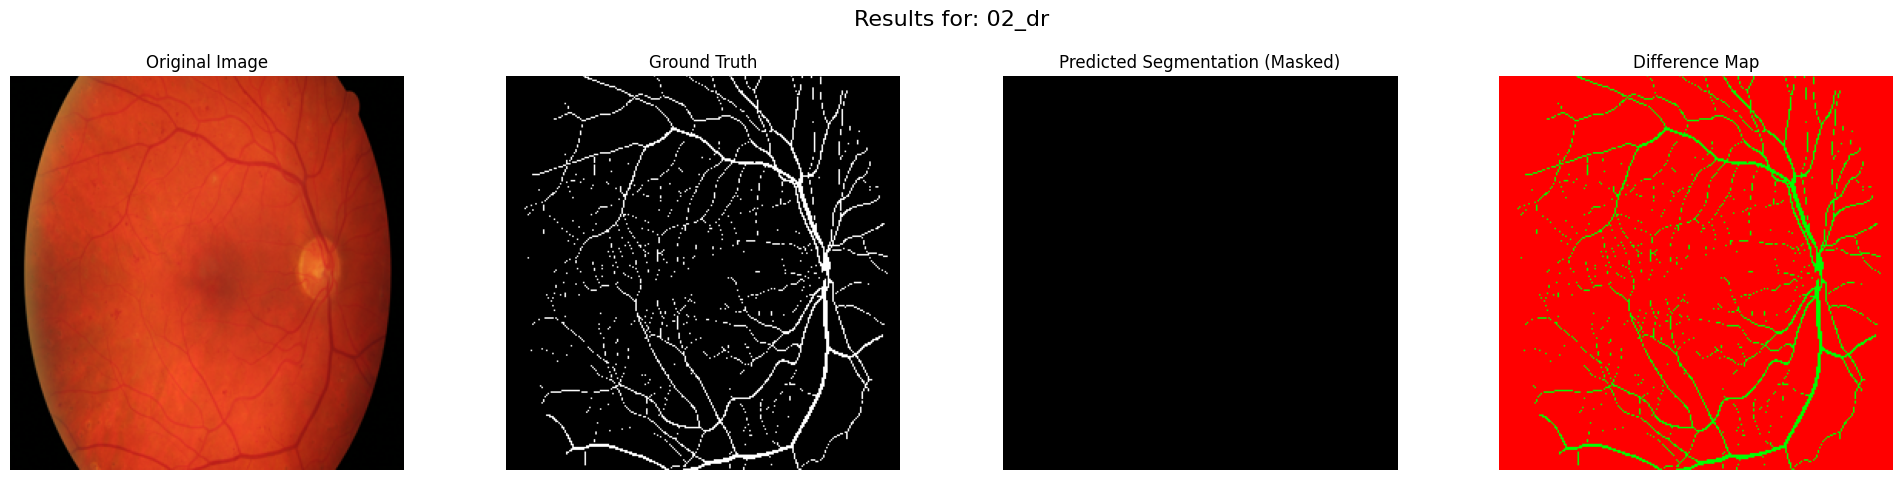

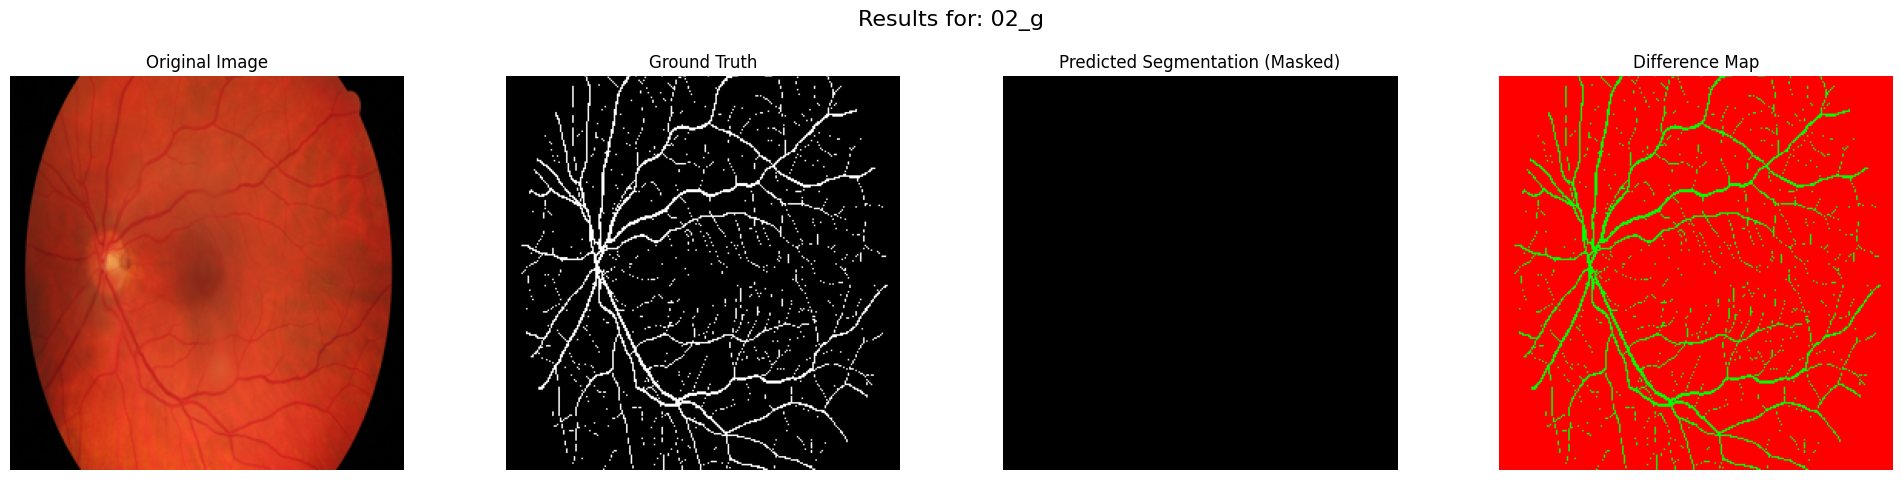

In [12]:
import torch
import torch.nn.functional as F
from torchvision import transforms as T
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

from DLModelUnet import UNetSmall

# --- Configuration ---
MODEL_WEIGHTS_PATH = 'model_final_unet.pth'
IMAGE_DIR = 'images/pictures/'  # Directory with images to predict on
MANUAL_LABEL_DIR = 'images/manual/'  # <-- Use this for ground truth labels
IMAGE_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def create_diffmap(label, pred):
    label = np.array(label)
    pred = np.array(pred)
    label_bin = (label > 0).astype(np.uint8)
    pred_bin = (pred > 0).astype(np.uint8)
    diff_map = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    diff_map[(label_bin == 0) & (pred_bin == 0)] = [0, 0, 0]
    diff_map[(label_bin == 1) & (pred_bin == 1)] = [0, 255, 0]
    diff_map[(label_bin == 0) & (pred_bin == 1)] = [255, 0, 0]
    diff_map[(label_bin == 1) & (pred_bin == 0)] = [0, 0, 255]
    return diff_map

inference_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def apply_fov_mask(pred_mask, mask_path):
    """
    Sets all pixels outside the field of view (FOV) to 0 (black) in the predicted mask.
    """
    mask = Image.open(mask_path).convert("L")
    mask = mask.resize((IMAGE_SIZE, IMAGE_SIZE), resample=Image.NEAREST)
    mask_np = (np.array(mask) > 0).astype(np.uint8)
    pred_mask_masked = pred_mask
    return pred_mask_masked

def predict_and_visualize_with_mask(model, image_path, ground_truth_path, mask_path):
    original_image = Image.open(image_path).convert("RGB")
    image_tensor = inference_transform(original_image).unsqueeze(0).to(DEVICE)
    label = Image.open(ground_truth_path).convert("L")
    label = label.resize((IMAGE_SIZE, IMAGE_SIZE), resample=Image.NEAREST)
    label_np = (np.array(label) > 0).astype(np.uint8)
    
    with torch.no_grad():
        output = model(image_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy().astype(np.uint8)
    
    # Apply FOV mask to prediction
    pred_mask_masked = apply_fov_mask(pred_mask, mask_path)
    diff_map = create_diffmap(label_np, pred_mask_masked)
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"Results for: {base_name}", fontsize=16)
    axes[0].imshow(original_image.resize((IMAGE_SIZE, IMAGE_SIZE)))
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(label_np, cmap='gray')
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')
    axes[2].imshow(pred_mask_masked, cmap='gray')
    axes[2].set_title("Predicted Segmentation (Masked)")
    axes[2].axis('off')
    axes[3].imshow(diff_map)
    axes[3].set_title("Difference Map")
    axes[3].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    if not os.path.exists(MODEL_WEIGHTS_PATH):
        print(f"Error: Model weights not found at '{MODEL_WEIGHTS_PATH}'")
        print("Please run train_unet.py first.")
    else:
        model = UNetSmall(in_channels=3, num_classes=2)
        model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
        model.to(DEVICE)
        model.eval()
        print("Model loaded successfully.")

        test_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.tif', '.tiff', '.png'))][:5]

        for file_name in test_files:
            base_name = os.path.splitext(file_name)[0]
            image_path = os.path.join(IMAGE_DIR, file_name)
            # Find the corresponding manual label file in images/manual/
            gt_label_path = None
            for ext in ('.tif', '.tiff', '.png', '.jpg'):
                candidate_path = os.path.join(MANUAL_LABEL_DIR, f"{base_name}{ext}")
                if os.path.exists(candidate_path):
                    gt_label_path = candidate_path
                    break
            # Find the corresponding FOV mask file in images/mask/
            mask_path = None
            for ext in ('.tif', '.tiff', '.png', '.jpg'):
                candidate_path = os.path.join('images/mask/', f"{base_name}_mask{ext}")
                if os.path.exists(candidate_path):
                    mask_path = candidate_path
                    break
            if gt_label_path and mask_path:
                predict_and_visualize_with_mask(model, image_path, gt_label_path, mask_path)
            elif not gt_label_path:
                print(f"Warning: Could not find a manual label for {file_name}. Skipping.")
            elif not mask_path:
                print(f"Warning: Could not find a FOV mask for {file_name}. Skipping.")

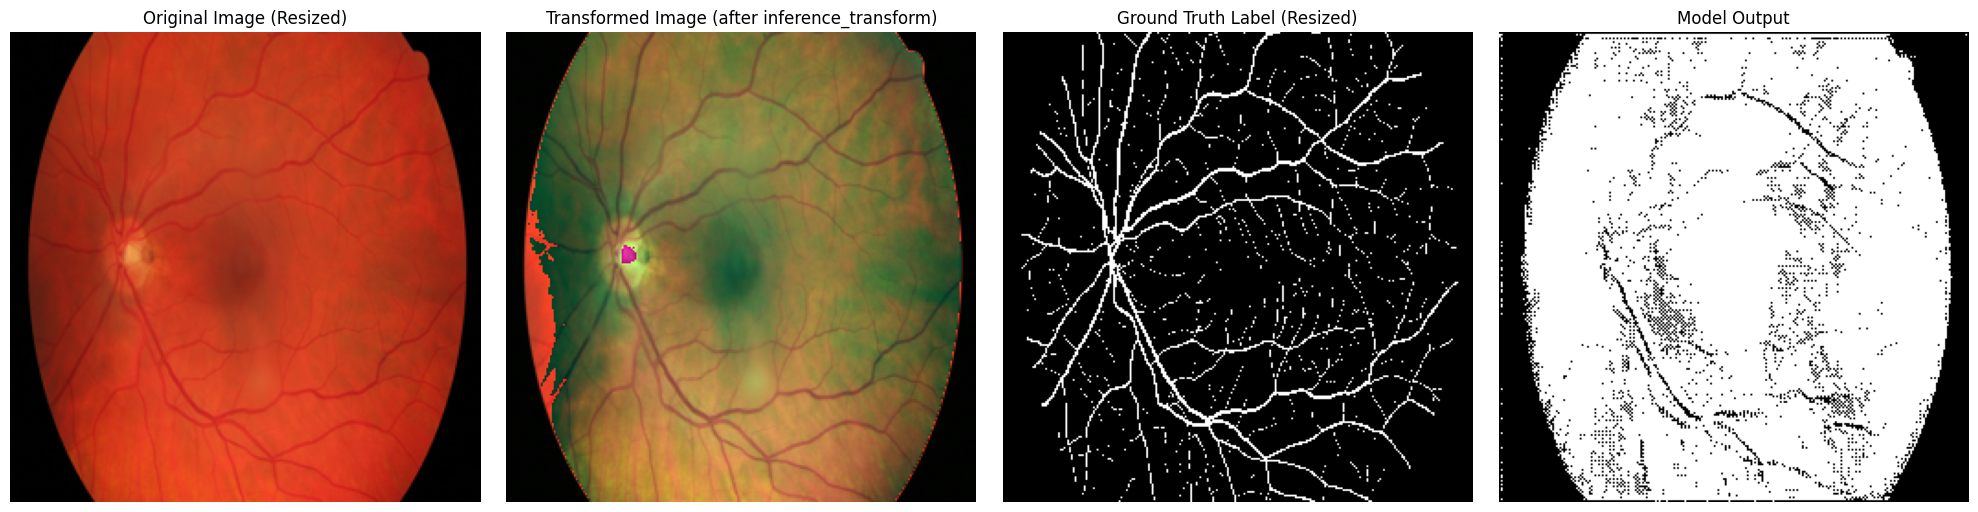

In [9]:
def visualize_input_transform(image_path, ground_truth_path):
    original_image = Image.open(image_path).convert("RGB")
    label = Image.open(ground_truth_path).convert("L")
    label = label.resize((IMAGE_SIZE, IMAGE_SIZE), resample=Image.NEAREST)
    label_np = (np.array(label) > 0).astype(np.uint8)

    # Apply the inference transform to the original image
    image_tensor = inference_transform(original_image).unsqueeze(0).to(DEVICE)  # Add unsqueeze and move to device
    
    # Convert the transformed tensor back to a PIL image for visualization
    transformed_image = T.ToPILImage()(image_tensor.squeeze(0).cpu().detach())  # Squeeze to remove batch dimension

    with torch.no_grad():
        model.eval()
        output = model(image_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(original_image.resize((IMAGE_SIZE, IMAGE_SIZE)))
    axes[0].set_title("Original Image (Resized)")
    axes[0].axis('off')

    axes[1].imshow(transformed_image)
    axes[1].set_title("Transformed Image (after inference_transform)")
    axes[1].axis('off')

    axes[2].imshow(label_np, cmap='gray')
    axes[2].set_title("Ground Truth Label (Resized)")
    axes[2].axis('off')
    
    axes[3].imshow(pred_mask, cmap='gray')
    axes[3].set_title("Model Output")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_input_transform(image_path, gt_label_path)